### All Code Comparison

In [1]:
import os
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
from hamming_channel_47 import HammingChannel47
from ldpc_channel import LdpcChannel
import matplotlib.pyplot as plt
import pickle
from ldpc_bpsk_gaussian_system import LdpcBpskGaussianSystem

#### Hamming

In [2]:
# 1. Escolha um valor de p. Utilize p = 0.5,0.2,0.1,0.05,0.02,0.01,0.005,...

snrs_db = np.arange(0, 10.5, 0.5) 
ps = []
R = 4/7
for snr_db in snrs_db:
    ps.append(Ei_N0_to_p(snr_db, R)) 
    
bit_values = [0, 1]
save_folder = "./bit_error_results"
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
method = "hamming"
for p in ps:
    print(f"p = {p}")
    
    # 2. Gere aleatoriamente cerca de 1 milhão de bits de informação
    # 3. Divida em grupos de K bits. Haverá L grupos
    save_path_original = save_folder + f"/{p}-{method}-bits-original.npy"    

    if not os.path.isfile(save_path_original):  
        random_info_bits = np.array(random.choices(bit_values, weights=[1, 1], k = int(1e6))) 
        k = 4
        original_bits_groups = random_info_bits.reshape(-1, k) 
        with open(save_path_original, "wb") as f:
            np.save(f, original_bits_groups)
    else:
        with open(save_path_original, "rb") as f:
            original_bits_groups = np.load(f)
            
    # 4: Gere as L palavras-código correspondentes a cada um dos grupos do item 3
    # 5: Simule o efeito do canal BSC trocando o valor dos bits das palavras código do item anterior 
    # com probabilidade p para todos os bits de todas as L palavras-código, gerando assim L palavras recebidas.
    # 6: Realize o processo de detecção por síndrome para cada uma das L palavras recebidas.
    # 7: Realize o processo de estimação sobre os bits de informação.
    save_path_decoded = save_folder + f"/{p}-{method}-bits-decoded.npy"

    if not os.path.isfile(save_path_decoded):
        hamming_channel = HammingChannel47(p)
        decoded_bits_groups = []
        for i in tqdm(range(original_bits_groups.shape[0])):
            decoded_bits_groups.append(hamming_channel.transmit(original_bits_groups[i])) 
        decoded_bits_groups = np.array(decoded_bits_groups)
        with open(save_path_decoded, 'wb') as f:
            np.save(f, decoded_bits_groups)
    else: 
        with open(save_path_decoded, "rb") as f:
            decoded_bits_groups = np.load(f)

p = 0.14252470370130643
p = 0.12873528209043172
p = 0.11516908862773423
p = 0.10194219854208608
p = 0.0891757908458275
p = 0.07699273024700704
p = 0.06551327242683047
p = 0.05484997901513444
p = 0.04510204743362156
p = 0.03634940131838471
p = 0.028647034206930377
p = 0.022020226921702468
p = 0.016461332099899972
p = 0.011928796627787897
p = 0.008348937375587728
p = 0.005620679255335825
p = 0.0036230245557679064
p = 0.0022245149617428073
p = 0.0012934879727222182
p = 0.0007076603075836241
p = 0.00036161635821507776


In [3]:
save_folder = "./bit_error_results"
info_bit_error_probas = []

for p in ps:
    save_path_original = save_folder + f"/{p}-{method}-bits-original.npy"
    with open(save_path_original, "rb") as f:
        original_bits_groups = np.load(f)

    save_path_decoded = save_folder + f"/{p}-{method}-bits-decoded.npy"
    with open(save_path_decoded, "rb") as f:
        decoded_bits_groups = np.load(f)
        
    original = original_bits_groups.reshape(-1)
    decoded = decoded_bits_groups.reshape(-1)
    info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
    info_bit_error_probas.append(info_bit_error_proba)

In [4]:
hamming_errors = info_bit_error_probas

In [5]:
hamming_errors

[0.119098,
 0.101465,
 0.084729,
 0.068658,
 0.055317,
 0.042901,
 0.032453,
 0.022871,
 0.01598,
 0.010913,
 0.006784,
 0.003982,
 0.002243,
 0.001206,
 0.000614,
 0.000249,
 0.000126,
 4.6e-05,
 1.5e-05,
 6e-06,
 2e-06]

### LDPC - Bit Flipping

In [6]:
#4/7 Rate
rate="4/7"
save_folder = "./bit_error_results_47"
hamming=False
dv=3
dc=7
N_values=[1001]
snrs_db = np.arange(0, 10.5, 0.5) 
ps = []
R = 4/7
for snr_db in snrs_db:
    ps.append(Ei_N0_to_p(snr_db, R)) 

In [7]:
def generate_groups(N, N_bits, ps):
    """
    dv = 3 # número de ramos que saem de cada v-node para a camada CND = número de 1s nas colunas
    dc = 7 # número de ramos que saem de cada c-node para a camada VND = número de 1s nas linhas
    N = 98 # tamanho da palavra código
    """
    n_groups = int(N_bits/N)
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    method = "ldpc"

    for p in ps:
        save_path_original = save_folder + f"/{N}-{p}-{method}-bits-original.npy"    

        if not os.path.isfile(save_path_original):  
            original_bits_groups = np.zeros((1, N_bits)).reshape(-1, N) 
            with open(save_path_original, "wb") as f:
                np.save(f, original_bits_groups)

        save_path_decoded = save_folder + f"/{N}-{p}-{method}-bits-decoded.npy"
        if not os.path.isfile(save_path_decoded):
            print(f"p = {p}")
            ldpc_channel = LdpcChannel(p, dv, dc, N, iterations=100)
            decoded_bits_groups = []
            for i in tqdm(range(n_groups)):
                decoded_bits_groups.append(ldpc_channel.transmit()) 
            decoded_bits_groups = np.array(decoded_bits_groups)
            with open(save_path_decoded, 'wb') as f:
                np.save(f, decoded_bits_groups)
        else: 
            with open(save_path_decoded, "rb") as f:
                decoded_bits_groups = np.load(f)

def get_info_bit_error_probas(N, ps):
    method = "ldpc"
    info_bit_error_probas = []

    for p in ps:
        save_path_original = save_folder + f"/{N}-{p}-{method}-bits-original.npy"
        with open(save_path_original, "rb") as f:
            original_bits_groups = np.load(f)

        save_path_decoded = save_folder + f"/{N}-{p}-{method}-bits-decoded.npy"
        with open(save_path_decoded, "rb") as f:
            decoded_bits_groups = np.load(f)
            
        original = original_bits_groups.reshape(-1)
        decoded = decoded_bits_groups.reshape(-1)
        info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
        info_bit_error_probas.append(info_bit_error_proba)
        
    return info_bit_error_probas

def get_probas_list_ldpc(N_values, ps):
    
    if hamming:
        info_bit_error_probas_hamming = []
        method = "hamming"

        for p in ps:
            save_path_original = save_folder + f"/{p}-{method}-bits-original.npy"
            with open(save_path_original, "rb") as f:
                original_bits_groups = np.load(f)

            save_path_decoded = save_folder + f"/{p}-{method}-bits-decoded.npy"
            with open(save_path_decoded, "rb") as f:
                decoded_bits_groups = np.load(f)
                
            original = original_bits_groups.reshape(-1)
            decoded = decoded_bits_groups.reshape(-1)
            info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
            info_bit_error_probas_hamming.append(info_bit_error_proba)
    
    probas_list = []
    
    for N in N_values:
        generate_groups(N=N, N_bits=N*1000, ps=ps)
        info_bit_error_probas = get_info_bit_error_probas(N=N, ps=ps)
        for i in range(len(info_bit_error_probas) - 1):
            if(info_bit_error_probas[i] == 0 and info_bit_error_probas[i+1] > 0):
                info_bit_error_probas[i+1] = 0
        probas_list.append(info_bit_error_probas)
    
    return probas_list

In [8]:
ldpc_bitflipping_errors = get_probas_list_ldpc(N_values, ps)

In [9]:
ldpc_bitflipping_errors = ldpc_bitflipping_errors[0]
ldpc_bitflipping_errors

[0.19223576423576424,
 0.17645754245754247,
 0.15903596403596404,
 0.1407982017982018,
 0.11982717282717283,
 0.09834965034965035,
 0.07655744255744255,
 0.05348951048951049,
 0.032655344655344656,
 0.0177022977022977,
 0.007581418581418581,
 0.0025994005994005994,
 0.0009660339660339661,
 0.0003956043956043956,
 0.00011588411588411588,
 0.0001018981018981019,
 1.3986013986013986e-05,
 5.994005994005994e-06,
 1.1988011988011987e-05,
 0.0,
 0.0]

### LDPC - Belief Propagation

In [10]:
N = 1001
n_groups = 20
N_bits = N * n_groups
dv = 3
dc = 7 
max_iter = 20
Eb = 1
R = 1 - dv/dc
snr_db_values_Ei = np.arange(0, 10.5, 0.25)
snr_db_values_Eb_coded = [Ei_snr_db_to_Eb_snr_db(i, R) for i in snr_db_values_Ei]
snr_db_values_Eb_uncoded = [Ei_snr_db_to_Eb_snr_db(i, 1) for i in snr_db_values_Ei]
N0_values_coded = [N0_from_db_value(i, Eb) for i in snr_db_values_Eb_coded]
N0_values_uncoded = [N0_from_db_value(i, Eb) for i in snr_db_values_Eb_uncoded]
original = np.zeros(N_bits)
info_bit_error_probas = []
uncoded_info_bit_error_probas = []

if not os.path.isfile("ldpc_belief_errors.pkl"):
    for N0_coded, N0_uncoded in zip(N0_values_coded, N0_values_uncoded):
        system_coded = LdpcBpskGaussianSystem(N0_coded, Eb, dv, dc, N, max_iter)
        system_uncoded = LdpcBpskGaussianSystem(N0_uncoded, Eb, dv, dc, N, max_iter)
        decoded_bits_groups = []
        uncoded_bits_groups = []
        for i in tqdm(range(n_groups)):
            decoded_bits_groups.append(system_coded.apply_noise_and_decode()) 
            uncoded_bits_groups.append(system_uncoded.get_uncoded_bits())
        decoded_bits_groups = np.array(decoded_bits_groups)
        uncoded_bits_groups = np.array(uncoded_bits_groups)
        decoded = decoded_bits_groups.reshape(-1)
        uncoded = uncoded_bits_groups.reshape(-1)
        info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
        info_bit_error_probas.append(info_bit_error_proba)
        uncoded_info_bit_error_proba = np.not_equal(original, uncoded).sum()/len(original)
        uncoded_info_bit_error_probas.append(uncoded_info_bit_error_proba)
        
    ldpc_belief_errors = info_bit_error_probas
    uncoded_ldpc_belief_errors = uncoded_info_bit_error_probas
    with open("ldpc_belief_errors.pkl", "wb") as f:
        pickle.dump(ldpc_belief_errors, f)
    with open("uncoded_ldpc_belief_errors.pkl", "wb") as f:
        pickle.dump(uncoded_ldpc_belief_errors, f)
else:
    with open("ldpc_belief_errors.pkl", "rb") as f:
        ldpc_belief_errors = pickle.load(f)
    with open("uncoded_ldpc_belief_errors.pkl", "rb") as f:
        uncoded_ldpc_belief_errors = pickle.load(f)

100%|██████████| 20/20 [00:00<00:00, 22.14it/s]


In [26]:
ldpc_belief_errors[23] = 0

In [27]:
ldpc_belief_errors

[0.13401598401598402,
 0.12832167832167832,
 0.11698301698301698,
 0.09945054945054944,
 0.0964035964035964,
 0.06683316683316683,
 0.053946053946053944,
 0.04080919080919081,
 0.022877122877122878,
 0.007192807192807193,
 0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [19]:
uncoded_ldpc_belief_errors[-3] = 0

In [20]:
uncoded_ldpc_belief_errors

[0.08061938061938062,
 0.07512487512487513,
 0.06863136863136864,
 0.05984015984015984,
 0.05544455544455545,
 0.0514985014985015,
 0.04795204795204795,
 0.041758241758241756,
 0.03791208791208791,
 0.032217782217782216,
 0.02992007992007992,
 0.025574425574425574,
 0.024175824175824177,
 0.01953046953046953,
 0.01803196803196803,
 0.015034965034965035,
 0.013786213786213787,
 0.01063936063936064,
 0.008691308691308691,
 0.007242757242757243,
 0.005294705294705295,
 0.004995004995004995,
 0.0043456543456543454,
 0.003946053946053946,
 0.001998001998001998,
 0.002197802197802198,
 0.0012487512487512488,
 0.0012987012987012987,
 0.0004995004995004995,
 0.0006993006993006993,
 0.0002997002997002997,
 0.00014985014985014985,
 0.0001998001998001998,
 0.00024975024975024975,
 9.99000999000999e-05,
 4.995004995004995e-05,
 4.995004995004995e-05,
 4.995004995004995e-05,
 0.0,
 0,
 0.0,
 0.0]

### New LDPC - Belief Propagation

In [13]:
n_groups = 5
max_iter = 20
Eb = 1
dv_values = [3]
dc_values = [6]

for dv, dc in zip(dv_values, dc_values):
    N1 = int(1000/dc) * dc
    N2 = N1 + dc
    if abs(N1 - 1000) < abs(N2 - 1000):
        N = N1
    else:
        N = N2
    print(f"\nValor de N = {N}\n")
    N_bits = N * n_groups
    R = 1 - dv/dc
    snr_db_values_Ei = np.arange(0, 10.5, 0.5)
    snr_db_values_Eb = [Ei_snr_db_to_Eb_snr_db(i, R) for i in snr_db_values_Ei]
    N0_values = [N0_from_db_value(i, Eb) for i in snr_db_values_Eb]
    original = np.zeros(N_bits)
    info_bit_error_probas = []
    uncoded_info_bit_error_probas = []
    suffix = f"R-{dc-dv}-{dc}"

    if not os.path.isfile(f"ldpc_belief_errors_new_final2_{suffix}.pkl"):
        for N0 in N0_values:
            system = LdpcBpskGaussianSystem(N0, Eb, dv, dc, N, max_iter)
            decoded_bits_groups = []
            uncoded_bits_groups = []
            for i in tqdm(range(n_groups)):
                decoded_bits_groups.append(system.apply_noise_and_decode()) 
                uncoded_bits_groups.append(system.get_uncoded_bits())
            decoded_bits_groups = np.array(decoded_bits_groups)
            uncoded_bits_groups = np.array(uncoded_bits_groups)
            decoded = decoded_bits_groups.reshape(-1)
            uncoded = uncoded_bits_groups.reshape(-1)
            info_bit_error_proba = np.not_equal(original, decoded).sum()/len(original)
            info_bit_error_probas.append(info_bit_error_proba)
            uncoded_info_bit_error_proba = np.not_equal(original, uncoded).sum()/len(original)
            uncoded_info_bit_error_probas.append(uncoded_info_bit_error_proba)
            
        ldpc_belief_errors_new = info_bit_error_probas
        with open(f"ldpc_belief_errors_new_final2_{suffix}.pkl", "wb") as f:
            pickle.dump(ldpc_belief_errors_new, f)
    else:
        with open(f"ldpc_belief_errors_new_final2_{suffix}.pkl", "rb") as f:
            ldpc_belief_errors_new = pickle.load(f)


Valor de N = 1002



100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


### Plot

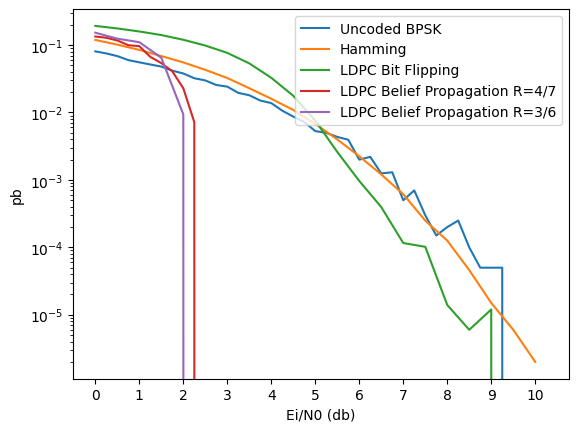

In [29]:
dv = 3
dc = 6
suffix = f"R-{dc-dv}-{dc}"
with open(f"ldpc_belief_errors_new_final2_{suffix}.pkl", "rb") as f:
    ldpc_belief_errors_new = pickle.load(f)
snrs_db = np.arange(0, 10.5, 0.5)
snr_db_values_Ei = np.arange(0, 10.5, 0.25)
plt.plot(snr_db_values_Ei, uncoded_ldpc_belief_errors) 
plt.plot(snrs_db, hamming_errors)
plt.plot(snrs_db, ldpc_bitflipping_errors)
plt.plot(snr_db_values_Ei, ldpc_belief_errors)
snr_db_values_Ei = np.arange(0, 10.5, 0.5)
plt.plot(snr_db_values_Ei, ldpc_belief_errors_new)
plt.yscale("log")
plt.legend(["Uncoded BPSK", "Hamming", "LDPC Bit Flipping", "LDPC Belief Propagation R=4/7", f"LDPC Belief Propagation R={dc-dv}/{dc}"], loc="upper right")
plt.xlabel("Ei/N0 (db)")
plt.ylabel("pb")
plt.xticks(np.arange(0, 11, 1))
plt.savefig("all_comparison.png")

### Graph representation for new ldpc code

In [30]:
from ldpc_bpsk_gaussian_system import generate_ldpc_csv
N = 1002
dv = 3
dc = 6
#max_iter = 20
#n_groups = 5
#Eb = 1
generate_ldpc_csv(dv, dc, N, "new_ldpc_code_graph.csv")